# Visualisation des données de loyers leboncoin

## Importations

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Vue d'ensemble

In [88]:
data = pd.read_csv('../data/LoyersFinal.csv')
data.describe()

,list_id,price,latitude,longitude,nb_pieces,surface
count,1.194000e+03,1194.00000,1194.000000,1194.000000,1144.000000,1114.000000
mean,2.918886e+09,1065.20268,48.860036,2.338511,1.335664,24.895871
std,3.955750e+07,258.24849,0.021235,0.040400,0.837185,10.820512
min,1.950691e+09,500.00000,48.817173,2.232957,1.000000,7.000000
25%,2.915946e+09,870.00000,48.841562,2.306609,1.000000,17.000000
50%,2.927266e+09,1050.00000,48.859156,2.339971,1.000000,24.000000
75%,2.932378e+09,1290.00000,48.879336,2.368968,2.000000,32.000000
max,2.935284e+09,1500.00000,48.901187,2.462427,23.000000,114.000000


## Relations entre toutes les paires de variables

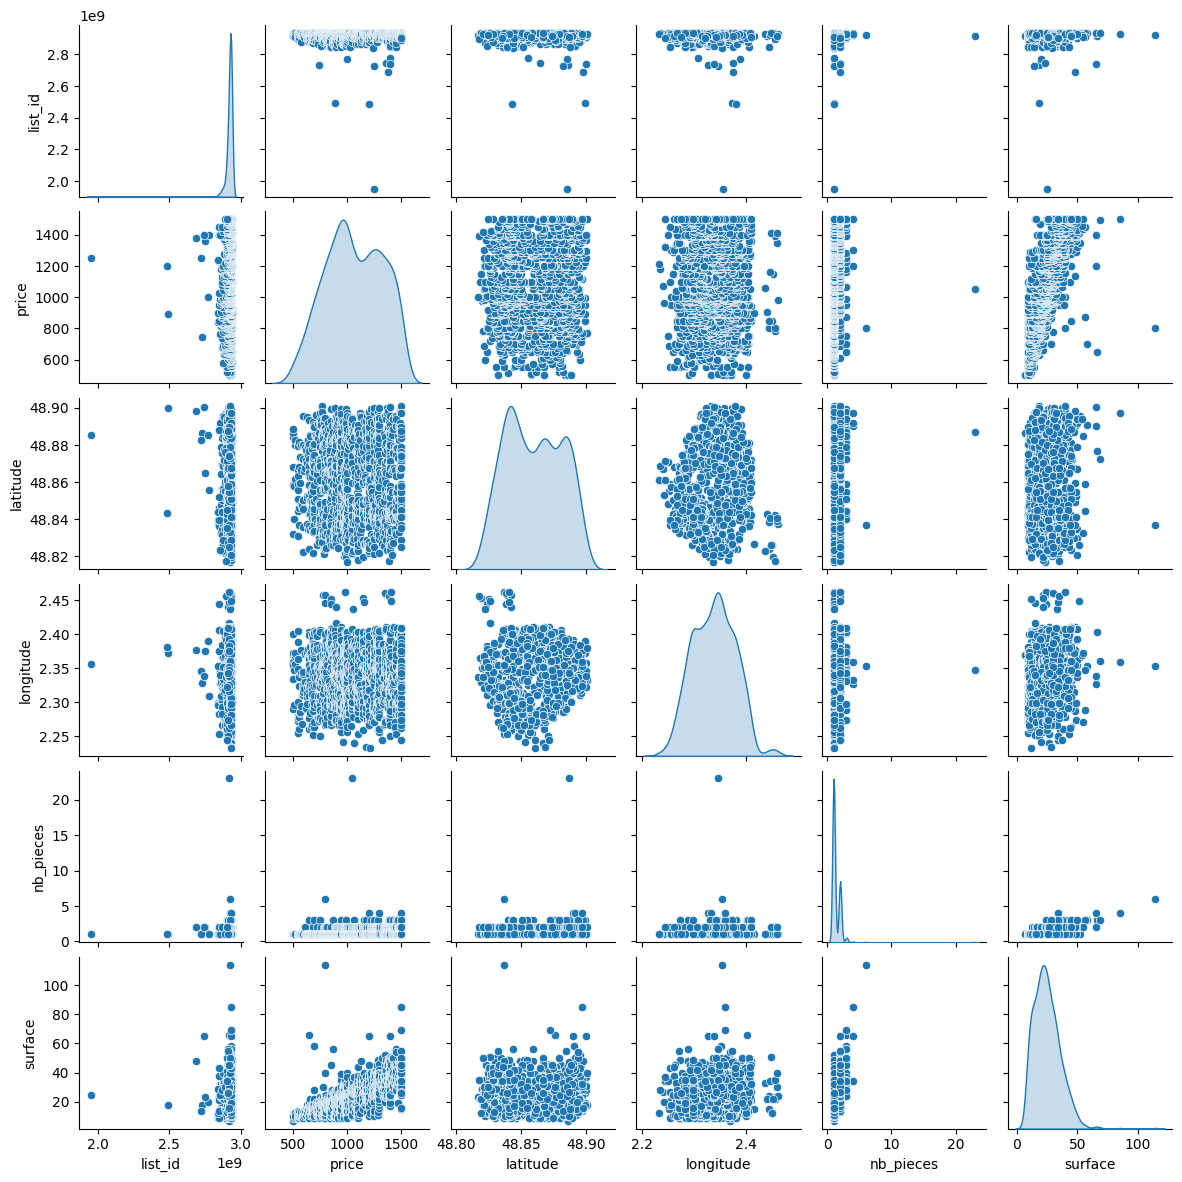

In [89]:
sns.pairplot(data, diag_kind="kde", height=2)  # "kde" pour un histogramme lissé
plt.show()

## Matrice de Correlation

,price,nb_pieces,surface
0,500,1.0,9.0
1,500,1.0,11.0
2,500,1.0,7.0
3,500,1.0,10.0
4,500,1.0,9.0
...,...,...,...
1189,1500,2.0,30.0
1190,1500,2.0,45.0
1191,1500,2.0,27.0
1192,1500,1.0,26.0


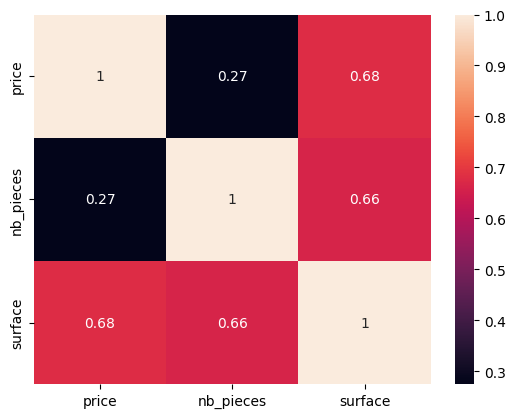

In [90]:
#[ETUD]
data2 = data.drop(['list_id', 'longitude', 'latitude','urls','first_publication_date'], axis=1)
MatCorr = data2.corr()
sns.heatmap(MatCorr, annot=True)
data2

## Analyse en composantes principales

/var/folders/1n/y44nm8wn4d7_c007zc7xn_hh0000gn/T/ipykernel_45837/2456412532.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=loadings.columns, y=pca.explained_variance_ratio_ * 100, palette="viridis")


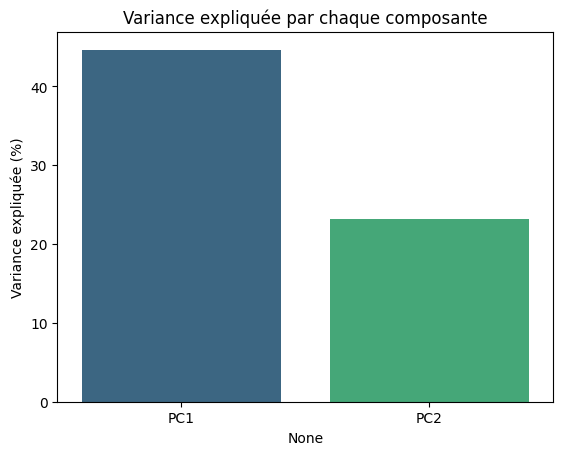

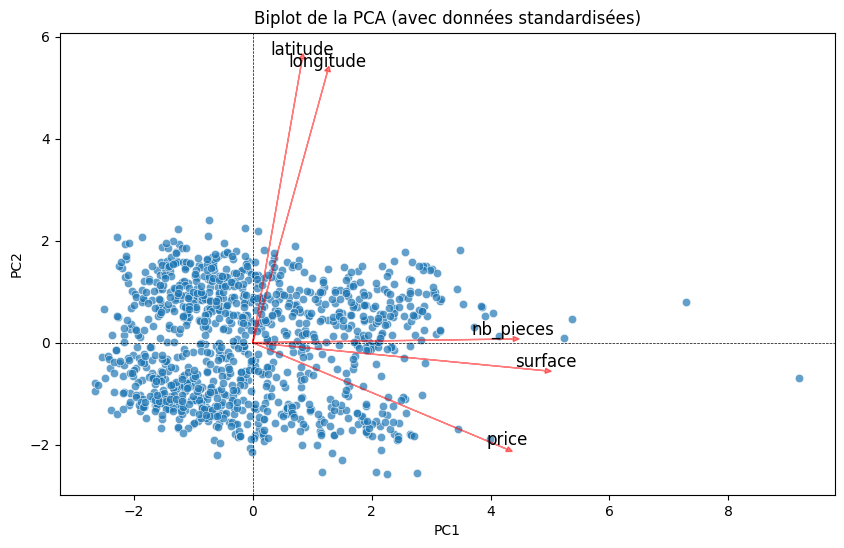

In [93]:
data3 = data.drop(['list_id','urls','first_publication_date'], axis=1)
data3 = data3.dropna()
# Normaliser les données avant la PCA
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data3)  # Transforme en numpy array

# PCA avec les données normalisées
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data_pca = pd.DataFrame(data_pca, columns=["PC1", "PC2"])

# Extraire les composantes pour le biplot
loadings = pd.DataFrame(pca.components_.T, index=data3.columns, columns=["PC1", "PC2"])

# 📌 Afficher la variance expliquée
sns.barplot(x=loadings.columns, y=pca.explained_variance_ratio_ * 100, palette="viridis")
plt.ylabel("Variance expliquée (%)")
plt.title("Variance expliquée par chaque composante")
plt.show()

# 📌 Tracer le biplot avec les flèches
fig, ax = plt.subplots(figsize=(10, 6))

# Nuage de points des individus
sns.scatterplot(data=data_pca, x="PC1", y="PC2", alpha=0.7, ax=ax)

scale_factor = 8  # Ajuste ce facteur pour mieux voir les flèches
for feature, (x, y) in loadings.iterrows():
    ax.arrow(0, 0, scale_factor * x, scale_factor * y, 
             color='red', alpha=0.5, head_width=0.1, head_length=0.1)
    ax.text(scale_factor * x, scale_factor * y, feature, 
            color='black', fontsize=12, ha="center", va="bottom")

# Ajouter des axes et un titre
ax.axhline(0, color="black", linestyle="--", linewidth=0.5)
ax.axvline(0, color="black", linestyle="--", linewidth=0.5)
ax.set_title("Biplot de la PCA (avec données standardisées)")
plt.show()

## Cercle de corrélation

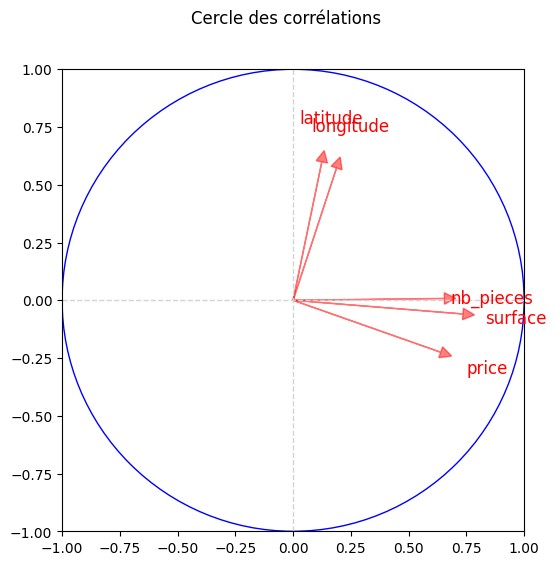

In [96]:
n = data_pca.shape[0]  # Nombre d'individus
p = data_pca.shape[1]  # Nombre de composantes principales
p_original = data3.shape[1]  # Nombre de variables initiales

# Calcul des valeurs propres
eigval = (n-1) / n * pca.explained_variance_
sqrt_eigval = np.sqrt(eigval)

# Correction de la taille de la matrice
corvar = np.zeros((p_original, p))

# Calcul des coordonnées des variables
for k in range(p):
    corvar[:, k] = pca.components_[k, :] * sqrt_eigval[k]

# Création d'un DataFrame avec les coordonnées des variables
coordvar = pd.DataFrame({
    'id': data3.columns,  # Noms des variables initiales
    'COR_1': corvar[:, 0],
    'COR_2': corvar[:, 1]
})

coordvar

# Création d'une figure vide (avec des axes entre -1 et 1 + le titre)
fig, axes = plt.subplots(figsize=(6,6))
fig.suptitle("Cercle des corrélations")

# Définition des limites des axes
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

# Ajout des axes
axes.axvline(x=0, color='lightgray', linestyle='--', linewidth=1)
axes.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)

# Ajout des noms des variables avec un facteur d'échelle pour la lisibilité
scale = 0.8  # Ajuste ce facteur si besoin
for j in range(len(coordvar)):
    x, y = coordvar["COR_1"][j], coordvar["COR_2"][j]
    axes.arrow(0, 0, x* scale, y* scale, color='red', alpha=0.5, 
               head_width=0.05, head_length=0.05)  # Ajout des flèches
    axes.text(x * (scale+0.25), y * (scale+0.25), coordvar["id"][j], color='red', 
              fontsize=12, ha="center", va="center")  # Ajout du texte

# Ajout du cercle unité
cercle = plt.Circle((0, 0), 1, color='blue', fill=False)
axes.add_patch(cercle)

# Aspect carré pour un cercle bien rond
axes.set_aspect('equal')

plt.show()

## Clustering (par K-Means)

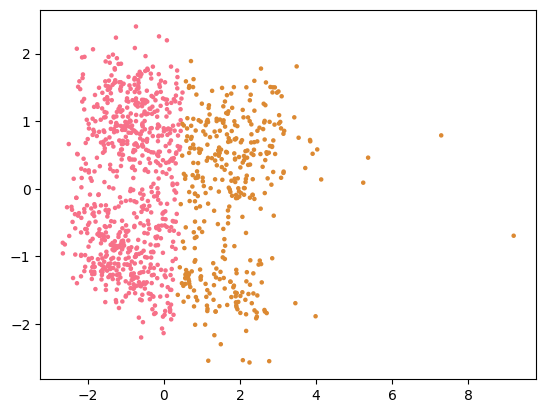

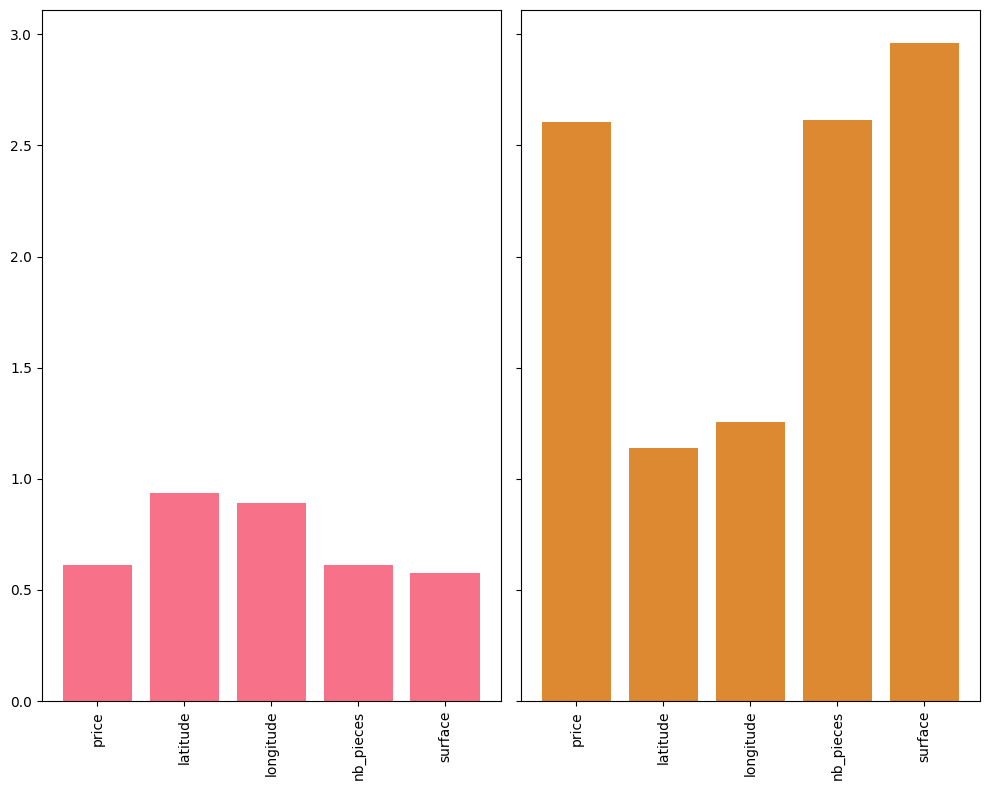

In [97]:
# Palette de couleurs avec 10 couleurs
palette10 = sns.color_palette('husl', 10)

# K-Means avec 8 clusters
km = KMeans(n_clusters=2, random_state=42)
pred = km.fit_predict(data_pca)

#accès aux colonnes
plt.scatter(data_pca.iloc[:, 0], data_pca.iloc[:, 1], color=[palette10[pred[i]] for i in range(len(data_pca))], s=5)

#calcul des centres
real_centers = np.exp(pca.inverse_transform(km.cluster_centers_))

# subplots
fig, axs = plt.subplots(km.n_clusters // 2, 2, figsize=(10, 8), sharey=True, sharex=True)

for i, k in enumerate(real_centers):
    axs.flatten()[i].bar(range(len(k)), k, color=palette10[i])
    axs.flatten()[i].set_xticks(range(len(k)))
    axs.flatten()[i].set_xticklabels(data3.columns, rotation="vertical")

plt.tight_layout()
plt.show()